# Packages & paths importation

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import random
import os
from skimage import io, color
from scipy import sparse
import math, numbers
import itertools
from itertools import islice
from warnings import warn
from numpy.lib.stride_tricks import as_strided
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

# Image processing tools

In [342]:
def pix_to_yuv(pix):
    y = 0.299*pix[0] + 0.587*pix[1] + 0.114* pix[2]
    U = 0.436*(pix[2]-y)/(1-0.114)
    V = 0.615*(pix[0]-y)/(1-0.299)
    return np.array([y,U,V])
    
def im_to_yuv(a):
    x,y,z = a.shape[0], a.shape[1], a.shape[2]
    a = a.reshape(x*y,z)
    a = np.apply_along_axis(pix_to_yuv, 1, a)
    a = a.reshape(x,y,z)
    return a

def YUV_to_RGB_affichage(pix):
    y,u,v = pix
    r = y + 1.13983*v
    g = y - 0.39465*u - 0.58060*v
    b = y + 2.03211*u
    if r > 1:
        r = 0. 
        g = 0.
        b = 0.
    if r < 0 :
        r = 0.
        g = 1.
        b = 0.
        
    if b > 1:
        r = 1.
        g = 1.
        b = 1.
    if b < 0:
        r = 1.
        g = 0.
        b = 0.
    return r,g,b


def YUV_to_RGB(pix):
    y,u,v = pix
    r = y + 1.13983*v
    g = y - 0.39465*u - 0.58060*v
    b = y + 2.03211*u
    return r,g,b

def YUV_to_RGB_corrected(pix):
    y,u,v = pix
    vmax = (1-y)/1.13983
    umax= (1-y)/2.03211
    vmin = -y/1.13983
    umin = -y/2.03211
    v = min(v,vmax)
    v = max(vmin,v)
    u = min(u,umax)
    u = max(umin,u)
    r = y + 1.13983*v
    g = y - 0.39465*u - 0.58060*v
    b = y + 2.03211*u
    if r > 1:
        r = 0. 
        g = 0.
        b = 0.
    if r < 0 :
        r = 0.
        g = 1.
        b = 0.
    if b > 1:
        r = 1.
        g = 1.
        b = 1.
    if b < 0:
        r = 1.
        g = 0.
        b = 0.
    return r,g,b

def im_to_rgb(a):
    x,y,z = a.shape[0], a.shape[1], a.shape[2]
    a = a.reshape(x*y,z)
    a = np.apply_along_axis(YUV_to_RGB, 1, a)
    a = a.reshape(x,y,z)
    for i in range(3):
        if np.min(a[:,:,i]) < 0:
            print('RGB should be positive')
            a[:,:,i][a[:,:,i]<0] = 0
        if np.max(a[:,:,i]) > 1:
            print('RGB should be smaller than 1')
            a[:,:,i][a[:,:,i]>1] = 1
    return a


def im_to_rgb_corrected(a):
    x,y,z = a.shape[0], a.shape[1], a.shape[2]
    a = a.reshape(x*y,z)
    a = np.apply_along_axis(YUV_to_RGB_corrected, 1, a)
    a = a.reshape(x,y,z)
    for i in range(3):
        if np.min(a[:,:,i]) < 0:
            print('RGB should be positive')
            a[:,:,i][a[:,:,i]<0] = 0
        if np.max(a[:,:,i]) > 1:
            print('RGB should be smaller than 1')
            a[:,:,i][a[:,:,i]>1] = 1
    return a

def im_to_rgb_without_correction(a):
    x,y,z = a.shape[0], a.shape[1], a.shape[2]
    a = a.reshape(x*y,z)
    a = np.apply_along_axis(YUV_to_RGB, 1, a)
    a = a.reshape(x,y,z)
    return a
    

def decolorize(img, p):

    # p is the probability of deleting a pixel
    W = np.random.binomial(1,1-p,img.shape)
    img[:,:,1]=np.multiply(W,img[:,:,1])
    img[:,:,2]=np.multiply(W,img[:,:,2])
    
    return [W,img]


def downsample(img, n_rows, n_cols):
    out = resize(img, (n_rows, n_cols))
    print((300*n_rows*n_cols)/img.size , ' percent of image lost')
    return out
    

# Graph-related tools

In [194]:
def exponential_distance(x,y, sig):
    '''Careful, take sigma square as an argument, not sigma'''
    if sig == 0:
        sig = 0.000001
    ans = math.exp(-((x-y)**2)/(2*sig))
    if np.isnan(ans):
        print('error : ', x, y, sig)
    return ans


def get_neighbors(i,j,k,n1,n2):
    '''
    i:lign
    j:column
    k: number of neighbors
    n1,n2: dimension de l'image globale (lignes, colonnes)
    '''
    min_row = max(0,i-k)
    max_row = min(n1,i+k+1)
    min_col = max(0,j-k)
    max_col = min(n2,j+k+1)
    row_indices = list(np.arange(min_row,max_row))
    col_indices = list(np.arange(min_col,max_col))
    grid = list(itertools.product(row_indices, col_indices))
    return grid

def get_neighbors_matrix(U,k):
    n1,n2 = U.shape
    res = np.empty((n1,n2),dtype=object)
    for i in range(n1):
        for j in range(n2):
            res[i,j]= get_neighbors(i,j,k,n1,n2)
    return res        
    
def build_weights(i,j, neighbors_pos,im, sig,method = 'gaussian'):
    '''
    Input:
    i,j : position of the pixel in the image: im
    neighbors_pos : a matrix where neighbors_pos[x,y] gives the absolute position of the neighbors in the image
    im : the image on which we are working

    Output:
    list with the same structure that neighbors_pos[x,y] list where the i-th element of the list contains
    the weight between the (x,y) pixel and the i-th neighbor in the neighbors_pos[x,y] list
    '''

    neighbors_position = neighbors_pos[i,j] # list containing the position of the neighbors for the x,y pixel
    array_value = np.array([im[elem] for elem in neighbors_position]) # intensity for those neighbors
    sigma = min(sig,np.var(array_value)) # estimated sigma using those neighbors
    if method == 'gaussian':
        res = [exponential_distance(im[elem],im[i,j],sigma) for elem in neighbors_position] # weights
    else:
        empirical_mean = np.mean(array_value)
        res = [(1+ 1/(sig)*(im[elem]- empirical_mean)*(im[i,j] - empirical_mean)) for elem in neighbors_position]
    return np.array(res)



def build_affinity(channel, k, sig, method='gaussian'):
    '''
    
    '''
    n1, n2 = channel.shape
    neighbors_pos = get_neighbors_matrix(channel,k)
    ans = np.zeros((channel.size,channel.size))
    for j in range(n2):
        for i in range(n1):
            weights = build_weights(i,j, neighbors_pos,channel,sig,method)
            row = np.array([i*n2 + j]*(len(neighbors_pos[i,j])))
            col = np.array([elem[0]*n2 + elem[1] for elem in neighbors_pos[i,j]])
            ans[row,col] = weights 
    return ans

def build_affinity_sparse(channel, k, sig,method='gaussian'):
    n1, n2 = channel.shape
    neighbors_pos = get_neighbors_matrix(channel,k)
    ans = sparse.lil_matrix((n1*n2,n1*n2))
    for j in range(n2):
        for i in range(n1):
            weights = build_weights(i,j, neighbors_pos,channel,sig,method)
            row = np.array([i*n2 + j]*(len(neighbors_pos[i,j])))
            col = np.array([int(elem[0])*n2 + int(elem[1]) for elem in neighbors_pos[i,j]])
            ans[row,col] = weights 
    return ans

def compute_laplacian(W, nor_type):
    N = W.shape[0]
    D = np.zeros((N,N))

    #We build the Laplacian
    if nor_type == 'unn':
        for  i in range(N):
            D[i,i] = sum(W[i,:])

        L = D - W 

    elif nor_type == 'nor':
        for  i in range(N):
            D[i,i] = sum(W[i,:])**(-1/2)

        L = np.eye(N) - D @ W @ D
        
    return L


def hard_hfs_sparse(channel,labeled_ind, l_val, k, sig, gamma, method):
    n1, n2 = channel.shape
    '''
    Compute the Hard HFS solution for the image colorisation on a single channel
    Param:
    - Channel: The Y element in the YUV color space
    - Labeled_ind: pixels for which we have the color values (U,V)
    - l_val : color values for those labeled_ind
    - k : Size of the neighborhood when computing the weights between the pixels
    - sig: sigma used in the distance function when computing the weights
    - gamma: parameter for the laplacain regularization
    - method: either 'gaussian' when the gaussian distance is used, 
              otherwise 'empirical correlation distance is used'
              
    Output:
    - out: contains the color values (either U or V) other arguments are used to monitor the HARD HFS process
    '''
    W = build_affinity(channel, k,sig,method)
    print('Similarities estimated')
    L = compute_laplacian(W,'unn')
    print('Laplacian built')
    
    l_idx = np.array([n2*elem[0] + elem[1] for elem in labeled_ind]) #l_idx liste de tuples
    u_idx = np.array([i for i in range(channel.size) if i not in l_idx])
    
    first = np.linalg.inv(L[np.ix_(u_idx,u_idx)] + gamma*np.eye(len(u_idx)))
    print('sparsity : ', np.sum(first==0)/np.size(first))
    plt.hist(first.flatten(), bins=100)
    second =  W[np.ix_(u_idx,l_idx)]
    weights = first @ second
    weights = weights/weights.sum(axis=1)[:,None]
    
    out = np.zeros(n1*n2)
    out[u_idx] = weights @ l_val 
    out[l_idx] = l_val 
    return [first, second, weights, out.reshape(channel.shape)]



def iterative_hfs_dual_channel_log(channel, T, labeled_ind, l_val_1,l_val_2, k, sig, method):
    '''
    Compute the iterative hfs solution for the image colorization on both channels simultaneously
    Param:
    - Channel: The Y element in the YUV color space
    - T : number of iteration for the HFS Solution, usually 10 iterations is sufficient
    - Labeled_ind: pixels for which we have the color values (U,V)
    - l_val_1 : U values for those labeled_ind
    - l_val_2 : V values for those labeled_ind
    - k : Size of the neighborhood when computing the weights between the pixels
    - sig: sigma used in the distance function when computing the weights
    - method: either 'gaussian' when the gaussian distance is used, 
              otherwise 'empirical correlation distance is used'
              
    Output:
    - res_list : list of U array values from which we can observe the evolution of the propagation
    - res_list_2 : list of V array values from which we can observe the evolution of the propagation
    '''
    n1, n2 = channel.shape
    W = build_affinity_sparse(channel, k, sig, method).tocsc()
    print('Similarities estimated')
    l_idx = np.array([n2*elem[0] + elem[1] for elem in labeled_ind]) #l_idx liste de tuples
    u_idx = np.array([i for i in range(channel.size) if i not in l_idx])
    
    res_list = []
    res_list_2 = []
    
    f = np.zeros((n1*n2,len(labeled_ind)))
    f_u = np.zeros((len(u_idx),len(labeled_ind)))
    f[l_idx,:] = np.eye(len(l_idx))
    res = np.zeros(n1*n2)
    res_2 = np.zeros(n1*n2)
    res[l_idx] = l_val_1
    res_2[l_idx] = l_val_2
    
    
    for t in range(T):
        res = np.zeros(n1*n2)
        res_2 = np.zeros(n1*n2)
        res[l_idx] = l_val_1
        res_2[l_idx] = l_val_2
        if t%5 ==0:
            print('iteration : ', t)
        f[u_idx,:] = f_u
        for i in range(len(u_idx)):
            u_i = u_idx[i]
            temp = W[:,u_i]/ np.sum(W[:,u_i])
            f_u[i,:][:,np.newaxis] = (f.T @ temp)
            
        f_u_nor = f_u / np.sum(np.abs(f_u), axis=1)[:,None]
        res[u_idx] = f_u_nor @ l_val_1
        res_2[u_idx] = f_u_nor @ l_val_2
        res[l_idx] = l_val_1
        res_2[l_idx] = l_val_2
        res_list += [res.reshape(channel.shape)]  
        res_list_2 += [res_2.reshape(channel.shape)]  
    
    return res_list,res_list_2

def colorize(image, n_points,gamma, sig= 0.001,method = 'hard_hfs', k = None, T = None):
    '''
    image should be yuv
    '''
    x_rand = random.sample(np.arange(image.shape[0]).tolist(),n_points)
    y_rand = random.sample(np.arange(image.shape[1]).tolist(),n_points)
    pts = list(zip(x_rand,y_rand))
    l_val_1 = []
    l_val_2 = []
    
    image_target = np.zeros(image.shape)
    image_target[:,:,0]= image[:,:,0]
    for elem in pts:
        image_target[elem] = image[elem]
        l_val_1 += [image[elem][1]]
        l_val_2 += [image[elem][2]]
    print('image parsed')
        
    channel = image_target[:,:,0]
    if method == 'hard_hfs':
        U = hard_hfs(channel, pts, l_val_1 ,gamma, sig)[-1]
        print('First channel computed')
        V = hard_hfs(channel, pts, l_val_2 ,gamma, sig)[-1]
        print('Second channel computed')
        image_colorized = np.stack([channel,U,V], axis = -1)
        f , ax = plt.subplots(1,3, figsize=(30,10))
        ax[0].imshow(im_to_rgb(image))
        ax[1].imshow(im_to_rgb(image_target))
        ax[2].imshow(im_to_rgb(image_colorized))
    
    elif method == 'iterative_hfs':
        U = iterative_hfs(channel, T, pts, l_val_1, k, method)
        print('First channel computed')
        V = iterative_hfs(channel, T, pts, l_val_2, k, method)
        print('Second channel computed')
        #nb_affichage = T//10
        image_colorized = np.stack([channel,U,V], axis = -1)
        f, ax = plt.subplots(1,3 , figsize=(30,10))
        ax[0].imshow(im_to_rgb(image))
        ax[1].imshow(im_to_rgb(image_target))
        ax[2].imshow(im_to_rgb(image_colorized))
    
    return [U,V]

def iterative_colorization(img, l_positions, l_values, k, T):
    '''
    Iterative Colorization function
    '''
    channel = img[:,:,0]
    l_val1 = [pix_to_yuv(elem)[1] for elem in l_values]
    l_val2 = [pix_to_yuv(elem)[2] for elem in l_values]
    chan1_log = iterative_hfs_log(channel, T, l_positions, l_val1, k, sig,method)
    print('First channel computed...')
    chan2_log = iterative_hfs_log(channel, T, l_positions, l_val2, k, sig,method)
    print('Second channel computed ...')
    
    rgb_images = [im_to_rgb(np.stack([channel,chan1_log[i],chan2_log[i]], axis = -1)) for i in range(T)]
    
    image_target = np.zeros(img.shape)
    image_target[:,:,0]= channel
    for elem in l_positions:
        image_target[elem] = img[elem]
    f,ax = plt.subplots(1,2,figsize=(8,15))
    ax[0].imshow(im_to_rgb(image_target))
    ax[1].imshow(rgb_images[-1])
    
    return rgb_images
    
    
def show_log(log):
    '''
    Function used to monitor the evolution of the propagation 
    '''
    T = len(log)
    f , ax = plt.subplots(2,3,figsize=(15,10))
    ax[0,0].imshow(log[0])
    ax[0,0].set_title('iteration : '+ str(1))
    ax[0,1].imshow(log[1])
    ax[0,1].set_title('iteration : '+ str(2))
    ax[0,2].imshow(log[2])
    ax[0,2].set_title('iteration : '+ str(3))
    
    ax[1,0].imshow(log[-3])
    ax[1,0].set_title('iteration : '+ str(T-2))
    ax[1,1].imshow(log[-2])
    ax[1,1].set_title('iteration : '+ str(T-1))
    ax[1,2].imshow(log[-1])
    ax[1,2].set_title('iteration : '+ str(T))

In [6]:
def final_plot(image,image_truth,Y_g, U_g, V_g,Y_ng,U_ng,V_ng,L_g,A_g,B_g,L_ng,A_ng,B_ng):
    f,ax = plt.subplots(2,3,figsize=(15,15))
    ax[0,0].imshow(im_to_rgb(image))
    ax[0,0].set_title('Labeled Image')
    ax[1,0].imshow(image_truth)
    ax[1,0].set_title('Ground Truth')
    ax[0,1].imshow(im_to_rgb(np.stack([Y_g,U_g[-1],V_g[-1]], axis = -1)))
    ax[0,1].set_title('Gaussian I-HFS YUV')
    ax[1,1].imshow(im_to_rgb(np.stack([Y_ng,U_ng[-1],V_ng[-1]], axis = -1)))
    ax[1,1].set_title('AutoCorr I-HFS YUV')
    ax[0,2].imshow(color.lab2rgb(np.stack([L_g,A_g[-1],B_g[-1]], axis = -1)))
    ax[0,2].set_title('Gaussian I-HFS LAB')
    ax[1,2].imshow(color.lab2rgb(np.stack([L_ng,A_ng[-1],B_ng[-1]], axis = -1)))
    ax[1,2].set_title('AutoCorr I-HFS LAB')

# Real world experiment

## Project Images

/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


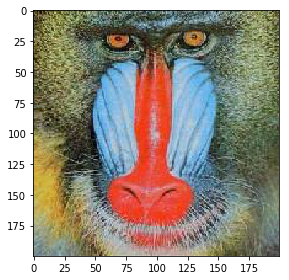

In [196]:
image_singe = io.imread('/Users/yoanrussac/Desktop/MVA/Imagerie Numérique/Project/Image/singe.jpg')
image_singe_resized = resize(image_singe, (int(image_singe.shape[0] / 2), int(image_singe.shape[1] / 2)))
image_singe_normalize = image_singe/255
image_singe_normalize_resized = resize(image_singe_normalize, (int(image_singe.shape[0] / 2), int(image_singe.shape[1] / 2)))
io.imshow(image_singe)

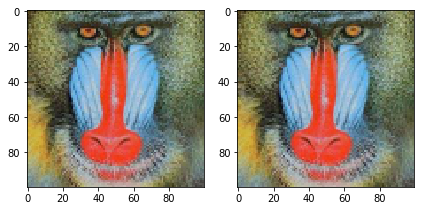

In [7]:
## Check that im_to_rgb and lab2rgb work properly
image_babouin_yuv = im_to_yuv(image_singe_normalize_resized)
image_babouin_lab = color.rgb2lab(image_singe_resized)
io.imshow_collection([im_to_rgb(image_babouin_yuv),color.lab2rgb(image_babouin_lab)])

In [12]:
# Random pixels revelation for the ape image
x_rand_babouin = np.random.randint(0,image_babouin_yuv.shape[0],100)
y_rand_babouin = np.random.randint(0,image_babouin_yuv.shape[1],100)

/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


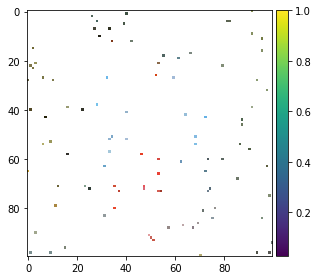

In [195]:
image_init_babouin = np.zeros(image_babouin_yuv.shape)
#image_init_babouin[:,:,0]= image_babouin_yuv[:,:,0]
image_init_babouin[:,:,0] = np.ones(image_babouin_yuv.shape[0:2])
pts_babouin = list(zip(x_rand_babouin,y_rand_babouin))
for elem in pts_babouin:
    image_init_babouin[elem] = image_babouin_yuv[elem]
io.imshow(im_to_rgb(image_init_babouin))

/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


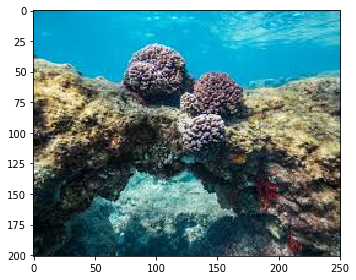

In [198]:
image_corail = io.imread('/Users/yoanrussac/Desktop/MVA/Imagerie Numérique/Project/Image/corail.jpg')
image_corail_resized = resize(image_corail, (int(image_corail.shape[0] / 2), int(image_corail.shape[1] / 2)))
image_corail_normalize = image_corail/255
image_corail_normalize_resized = resize(image_corail_normalize, (int(image_corail.shape[0] / 2), int(image_corail.shape[1] / 2)))
io.imshow(image_corail)

In [25]:
# Random pixels revelation for the coral image
x_rand_corail = np.random.randint(0,image_corail_yuv.shape[0],100)
y_rand_corail = np.random.randint(0,image_corail_yuv.shape[1],100)

/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


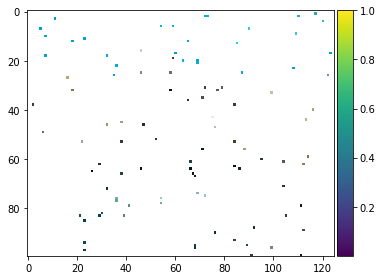

In [113]:
image_init_corail = np.zeros(image_corail_yuv.shape)
#image_init_corail[:,:,0]= image_corail_yuv[:,:,0]
image_init_corail[:,:,0] = np.ones(image_corail_yuv.shape[0:2])
pts_corail = list(zip(x_rand_corail,y_rand_corail))
for elem in pts_corail:
    image_init_corail[elem] = image_corail_yuv[elem]
io.imshow(im_to_rgb(image_init_corail))

/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


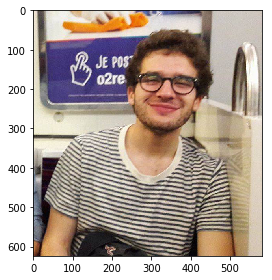

In [200]:
image_yo = io.imread(path_yo)
image_yo_resized = resize(image_yo, (int(image_yo.shape[0] / 6), int(image_yo.shape[1] / 6)))
image_yo_normalize = image_yo/255
image_yo_normalize_resized = resize(image_yo_normalize, (int(image_yo.shape[0] / 6), int(image_yo.shape[1] / 6)))
io.imshow(image_yo)

In [33]:
# Random pixels revelation for Yoan image
x_rand_yo = np.random.randint(0,image_yo_yuv.shape[0],100)
y_rand_yo = np.random.randint(0,image_yo_yuv.shape[1],100)

/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


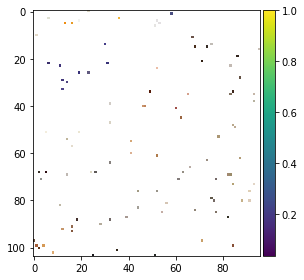

In [114]:
image_init_yo = np.zeros(image_yo_yuv.shape)
#image_init_yo[:,:,0]= image_yo_yuv[:,:,0]
image_init_yo[:,:,0] = np.ones(image_yo_yuv.shape[0:2])
pts_yo = list(zip(x_rand_yo,y_rand_yo))
for elem in pts_yo:
    image_init_yo[elem] = image_yo_yuv[elem]
io.imshow(im_to_rgb(image_init_yo))

# Hard HFS Part

Similarities estimated
Laplacian built
sparsity :  0.0
Similarities estimated
Laplacian built
sparsity :  0.0


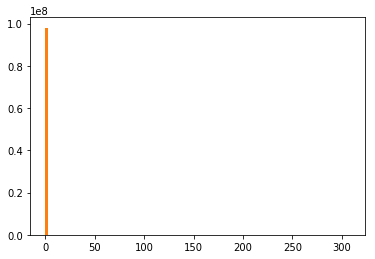

In [15]:
### HARD HFS YUV Gaussian Ape
image_target = image_babouin_yuv
Y_babouin_hard_hfs = image_target[:,:,0]
pix_kept_babouin = list(zip(x_rand_babouin,y_rand_babouin))
k = 4
sig = 0.0005
gamma = 0.001
labeled_ind = pix_kept_babouin
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_babouin_hard_hfs = hard_hfs_sparse(Y_babouin_hard_hfs,labeled_ind, l_val_1 ,k, sig, gamma, method = 'gaussian')
V_babouin_hard_hfs = hard_hfs_sparse(Y_babouin_hard_hfs,labeled_ind, l_val_2 ,k, sig, gamma, method = 'gaussian')


Similarities estimated
Laplacian built
sparsity :  0.0
Similarities estimated
Laplacian built
sparsity :  0.0


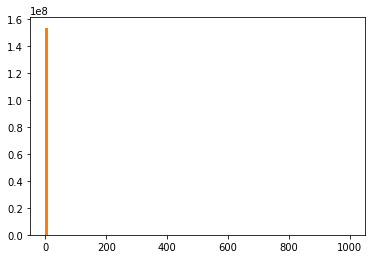

In [41]:
### HARD HFS YUV Gaussian Coral
image_target = image_corail_yuv
Y_corail_hard_hfs = image_target[:,:,0]
pix_kept_corail = list(zip(x_rand_corail,y_rand_corail))
k = 4
sig = 0.000005
gamma = 0.001
labeled_ind = pix_kept_corail
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_corail_hard_hfs = hard_hfs_sparse(Y_corail_hard_hfs,labeled_ind, l_val_1 ,k, sig, gamma, method = 'gaussian')
V_corail_hard_hfs = hard_hfs_sparse(Y_corail_hard_hfs,labeled_ind, l_val_2 ,k, sig, gamma, method = 'gaussian')


Similarities estimated
Laplacian built
sparsity :  0.0
Similarities estimated
Laplacian built
sparsity :  0.0


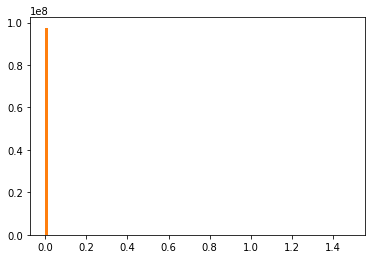

In [46]:
### HARD HFS YUV Gaussian - Yoan
image_target = image_yo_yuv
Y_yo_hard_hfs = image_target[:,:,0]
pix_kept_yo = list(zip(x_rand_yo,y_rand_yo))
k = 4
sig = 0.005
gamma = 0.001
labeled_ind = pix_kept_yo
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_yo_hard_hfs = hard_hfs_sparse(Y_yo_hard_hfs,labeled_ind, l_val_1 ,k, sig, gamma, method = 'gaussian')
V_yo_hard_hfs = hard_hfs_sparse(Y_yo_hard_hfs,labeled_ind, l_val_2 ,k, sig, gamma, method = 'gaussian')


RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


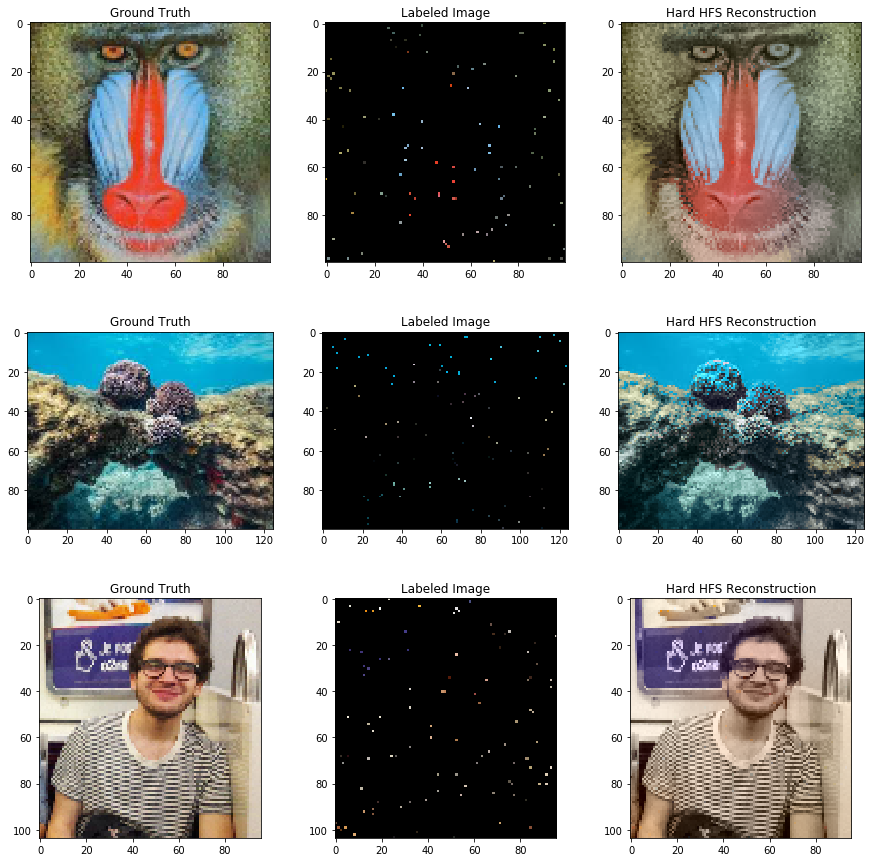

In [57]:
f,ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_babouin_yuv))
ax[0,0].set_title('Ground Truth')
ax[0,1].imshow(im_to_rgb(image_init_babouin))
ax[0,1].set_title('Labeled Image')
ax[0,2].imshow(im_to_rgb(np.stack([Y_babouin_hard_hfs, U_babouin_hard_hfs[-1],
                                      V_babouin_hard_hfs[-1]],axis=-1)))
ax[0,2].set_title('Hard HFS Reconstruction')

ax[1,0].imshow(im_to_rgb(image_corail_yuv))
ax[1,0].set_title('Ground Truth')
ax[1,1].imshow(im_to_rgb(image_init_corail))
ax[1,1].set_title('Labeled Image')
ax[1,2].imshow(im_to_rgb(np.stack([Y_corail_hard_hfs, U_corail_hard_hfs[-1],
                                      V_corail_hard_hfs[-1]],axis=-1)))
ax[1,2].set_title('Hard HFS Reconstruction')


ax[2,0].imshow(im_to_rgb(image_yo_yuv))
ax[2,0].set_title('Ground Truth')
ax[2,1].imshow(im_to_rgb(image_init_yo))
ax[2,1].set_title('Labeled Image')
ax[2,2].imshow(im_to_rgb(np.stack([Y_yo_hard_hfs, U_yo_hard_hfs[-1],
                                      V_yo_hard_hfs[-1]],axis=-1)))
ax[2,2].set_title('Hard HFS Reconstruction')

f.show()
    
    
    
    

RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


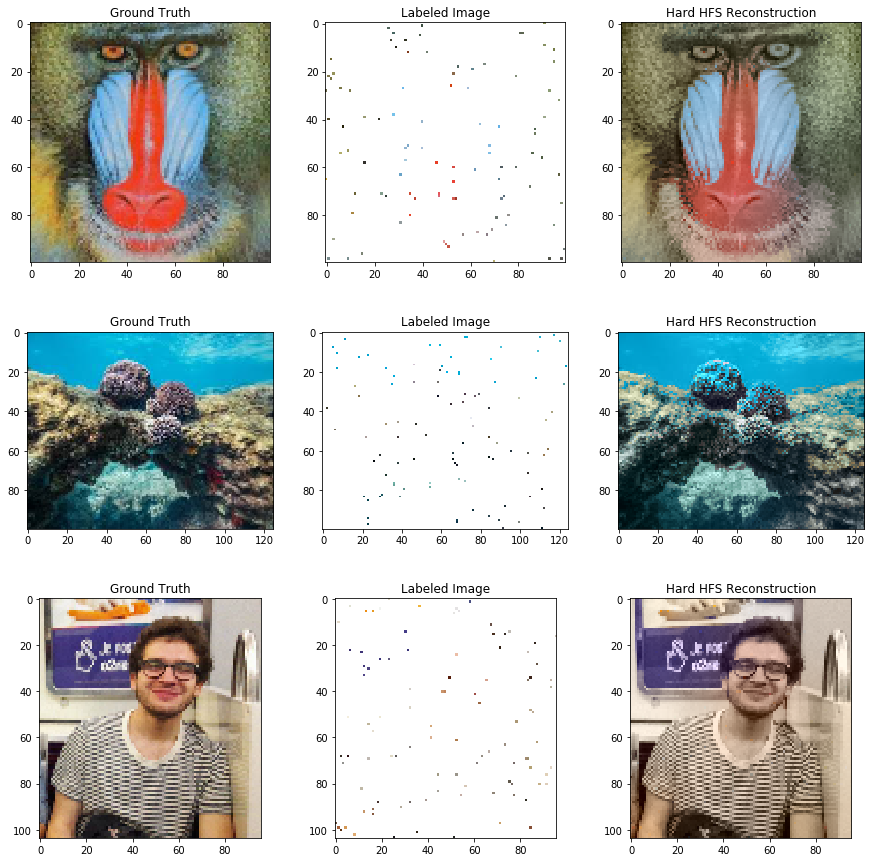

In [115]:
f,ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_babouin_yuv))
ax[0,0].set_title('Ground Truth')
ax[0,1].imshow(im_to_rgb(image_init_babouin))
ax[0,1].set_title('Labeled Image')
ax[0,2].imshow(im_to_rgb(np.stack([Y_babouin_hard_hfs, U_babouin_hard_hfs[-1],
                                      V_babouin_hard_hfs[-1]],axis=-1)))
ax[0,2].set_title('Hard HFS Reconstruction')

ax[1,0].imshow(im_to_rgb(image_corail_yuv))
ax[1,0].set_title('Ground Truth')
ax[1,1].imshow(im_to_rgb(image_init_corail))
ax[1,1].set_title('Labeled Image')
ax[1,2].imshow(im_to_rgb(np.stack([Y_corail_hard_hfs, U_corail_hard_hfs[-1],
                                      V_corail_hard_hfs[-1]],axis=-1)))
ax[1,2].set_title('Hard HFS Reconstruction')


ax[2,0].imshow(im_to_rgb(image_yo_yuv))
ax[2,0].set_title('Ground Truth')
ax[2,1].imshow(im_to_rgb(image_init_yo))
ax[2,1].set_title('Labeled Image')
ax[2,2].imshow(im_to_rgb(np.stack([Y_yo_hard_hfs, U_yo_hard_hfs[-1],
                                      V_yo_hard_hfs[-1]],axis=-1)))
ax[2,2].set_title('Hard HFS Reconstruction')

f.show()
    
    
    
    

# Iterative HFS

In [68]:
### YUV Gaussian- Ape Image
image_target = image_babouin_yuv
Y_babouin_g = image_target[:,:,0]
pix_kept_babouin = list(zip(x_rand_babouin,y_rand_babouin))
k = 3
T = 12
sig = 0.0025
labeled_ind = pix_kept_babouin
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_babouin_g, V_babouin_g = iterative_hfs_dual_channel_log(Y_babouin_g, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'gaussian')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


In [82]:
### YUV Gaussian - Coral Image
image_target = image_corail_yuv
Y_corail_g = image_target[:,:,0]
pix_kept = list(zip(x_rand_corail,y_rand_corail))
k = 3
T = 12
sig = 0.001
labeled_ind = pix_kept
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_corail_g, V_corail_g = iterative_hfs_dual_channel_log(Y_corail_g, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'gaussian')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


In [93]:
### YUV Gaussian - Yoan Image
image_target = image_yo_yuv
Y_yo_g = image_target[:,:,0]
pix_kept = list(zip(x_rand_yo,y_rand_yo))
k = 3
T = 12
sig = 0.01
labeled_ind = pix_kept
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_yo_g, V_yo_g = iterative_hfs_dual_channel_log(Y_yo_g, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'gaussian')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


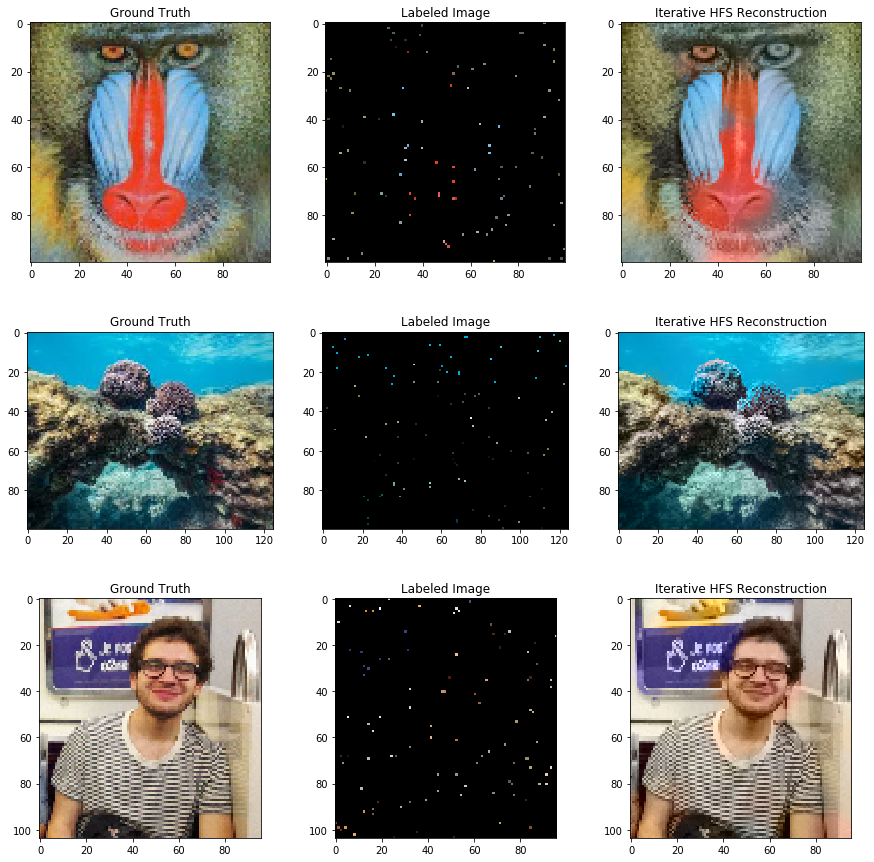

In [97]:
f,ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_babouin_yuv))
ax[0,0].set_title('Ground Truth')
ax[0,1].imshow(im_to_rgb(image_init_babouin))
ax[0,1].set_title('Labeled Image')
ax[0,2].imshow(im_to_rgb(np.stack([Y_babouin_g, U_babouin_g[-1],
                                      V_babouin_g[-1]],axis=-1)))
ax[0,2].set_title('Iterative HFS Reconstruction')

ax[1,0].imshow(im_to_rgb(image_corail_yuv))
ax[1,0].set_title('Ground Truth')
ax[1,1].imshow(im_to_rgb(image_init_corail))
ax[1,1].set_title('Labeled Image')
ax[1,2].imshow(im_to_rgb(np.stack([Y_corail_g, U_corail_g[-1],
                                      V_corail_g[-1]],axis=-1)))
ax[1,2].set_title('Iterative HFS Reconstruction')


ax[2,0].imshow(im_to_rgb(image_yo_yuv))
ax[2,0].set_title('Ground Truth')
ax[2,1].imshow(im_to_rgb(image_init_yo))
ax[2,1].set_title('Labeled Image')
ax[2,2].imshow(im_to_rgb(np.stack([Y_yo_g, U_yo_g[-1],
                                      V_yo_g[-1]],axis=-1)))
ax[2,2].set_title('Iterative HFS Reconstruction')

f.show()
    
    
    
    

RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


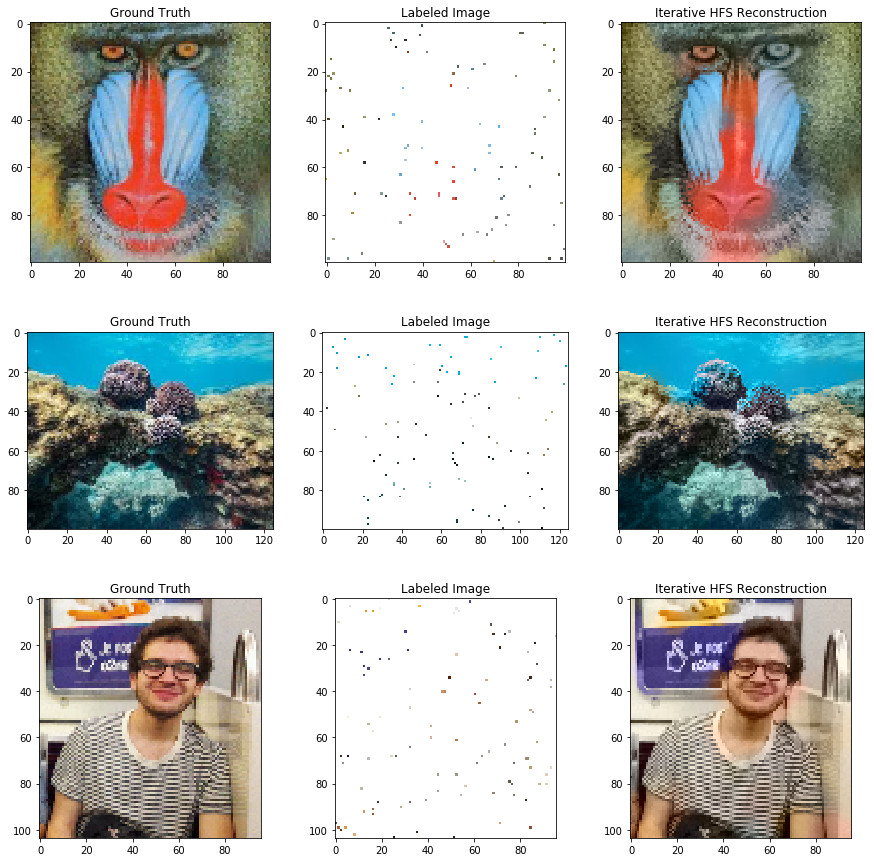

In [116]:
f,ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_babouin_yuv))
ax[0,0].set_title('Ground Truth')
ax[0,1].imshow(im_to_rgb(image_init_babouin))
ax[0,1].set_title('Labeled Image')
ax[0,2].imshow(im_to_rgb(np.stack([Y_babouin_g, U_babouin_g[-1],
                                      V_babouin_g[-1]],axis=-1)))
ax[0,2].set_title('Iterative HFS Reconstruction')

ax[1,0].imshow(im_to_rgb(image_corail_yuv))
ax[1,0].set_title('Ground Truth')
ax[1,1].imshow(im_to_rgb(image_init_corail))
ax[1,1].set_title('Labeled Image')
ax[1,2].imshow(im_to_rgb(np.stack([Y_corail_g, U_corail_g[-1],
                                      V_corail_g[-1]],axis=-1)))
ax[1,2].set_title('Iterative HFS Reconstruction')


ax[2,0].imshow(im_to_rgb(image_yo_yuv))
ax[2,0].set_title('Ground Truth')
ax[2,1].imshow(im_to_rgb(image_init_yo))
ax[2,1].set_title('Labeled Image')
ax[2,2].imshow(im_to_rgb(np.stack([Y_yo_g, U_yo_g[-1],
                                      V_yo_g[-1]],axis=-1)))
ax[2,2].set_title('Iterative HFS Reconstruction')

f.show()
    
    
    
    

# Different Distance Comparison


In [133]:
### YUV using non_Gaussian Distance - Ape Image
image_target = image_babouin_yuv
Y_babouin_ng = image_target[:,:,0]
pix_kept_babouin = list(zip(x_rand_babouin,y_rand_babouin))
k = 3
T = 12
sig = 0.05
labeled_ind = pix_kept_babouin
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_babouin_ng, V_babouin_ng = iterative_hfs_dual_channel_log(Y_babouin_ng, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'else')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


In [143]:
### YUV using non_Gaussian Distance - Coral Image
image_target = image_corail_yuv
Y_corail_ng = image_target[:,:,0]
pix_kept_corail = list(zip(x_rand_corail,y_rand_corail))
k = 3
T = 12
sig = 500
labeled_ind = pix_kept_corail
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_corail_ng, V_corail_ng = iterative_hfs_dual_channel_log(Y_corail_ng, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'else')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


In [147]:
### YUV using non_Gaussian Distance - Yoan Image
image_target = image_yo_yuv
Y_yo_ng = image_target[:,:,0]
pix_kept_yo = list(zip(x_rand_yo,y_rand_yo))
k = 3
T = 12
sig = 1
labeled_ind = pix_kept_yo
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_yo_ng, V_yo_ng = iterative_hfs_dual_channel_log(Y_yo_ng, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'else')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


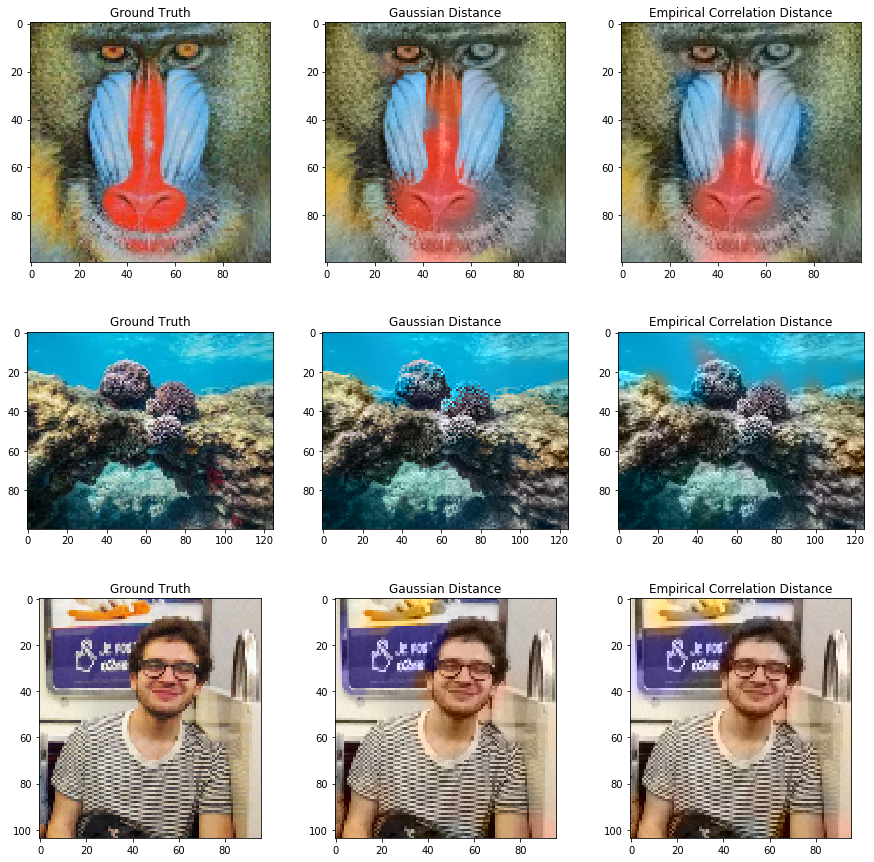

In [150]:
f,ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_babouin_yuv))
ax[0,0].set_title('Ground Truth')
ax[0,1].imshow(im_to_rgb(np.stack([Y_babouin_g, U_babouin_g[-1],
                                      V_babouin_g[-1]],axis=-1)))
ax[0,1].set_title('Gaussian Distance')
ax[0,2].imshow(im_to_rgb(np.stack([Y_babouin_ng, U_babouin_ng[-1],
                                      V_babouin_ng[-1]],axis=-1)))
ax[0,2].set_title('Empirical Correlation Distance')

ax[1,0].imshow(im_to_rgb(image_corail_yuv))
ax[1,0].set_title('Ground Truth')
ax[1,1].imshow(im_to_rgb(np.stack([Y_corail_g, U_corail_g[-1],
                                      V_corail_g[-1]],axis=-1)))
ax[1,1].set_title('Gaussian Distance')
ax[1,2].imshow(im_to_rgb(np.stack([Y_corail_ng, U_corail_ng[-1],
                                      V_corail_ng[-1]],axis=-1)))
ax[1,2].set_title('Empirical Correlation Distance')


ax[2,0].imshow(im_to_rgb(image_yo_yuv))
ax[2,0].set_title('Ground Truth')
ax[2,1].imshow(im_to_rgb(np.stack([Y_yo_g, U_yo_g[-1],
                                      V_yo_g[-1]],axis=-1)))
ax[2,1].set_title('Gaussian Distance')
ax[2,2].imshow(im_to_rgb(np.stack([Y_yo_ng, U_yo_ng[-1],
                                      V_yo_ng[-1]],axis=-1)))
ax[2,2].set_title('Empirical Correlation Distance')

f.show()   

# Color Space Influence

In [161]:
### LAB Color Space with Gaussian Distance - Ape Image
image_target = image_babouin_lab
Y_babouin_lab_g = image_target[:,:,0]
pix_kept = list(zip(x_rand_babouin,y_rand_babouin))
k = 3
T = 15
sig = 20
labeled_ind = pix_kept
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_babouin_lab_g, V_babouin_lab_g = iterative_hfs_dual_channel_log(Y_babouin_lab_g, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'gaussian')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


In [172]:
### LAB Color Space with Gaussian Distance - Coral Image
image_target = image_corail_lab
Y_corail_lab_g = image_target[:,:,0]
pix_kept = list(zip(x_rand_corail,y_rand_corail))
k = 3
T = 15
sig = 5
labeled_ind = pix_kept
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_corail_lab_g, V_corail_lab_g = iterative_hfs_dual_channel_log(Y_corail_lab_g, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'gaussian')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


In [181]:
### LAB Color Space with Gaussian Distance - Yoan Image
image_target = image_yo_lab
Y_yo_lab_g = image_target[:,:,0]
pix_kept = list(zip(x_rand_yo,y_rand_yo))
k = 3
T = 12
sig = 500
labeled_ind = pix_kept
l_val_1 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],1]
l_val_2 = image_target[[elem[0] for elem in labeled_ind], [elem[1] for elem in labeled_ind],2]
U_yo_lab_g, V_yo_lab_g = iterative_hfs_dual_channel_log(Y_yo_lab_g, T, labeled_ind, l_val_1,l_val_2, k, sig,method = 'gaussian')

Similarities estimated
iteration :  0


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:219: RuntimeWarning: invalid value encountered in true_divide


iteration :  5
iteration :  10


RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/color/colorconv.py:985: UserWarning: Color data out of range: Z < 0 in 11 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


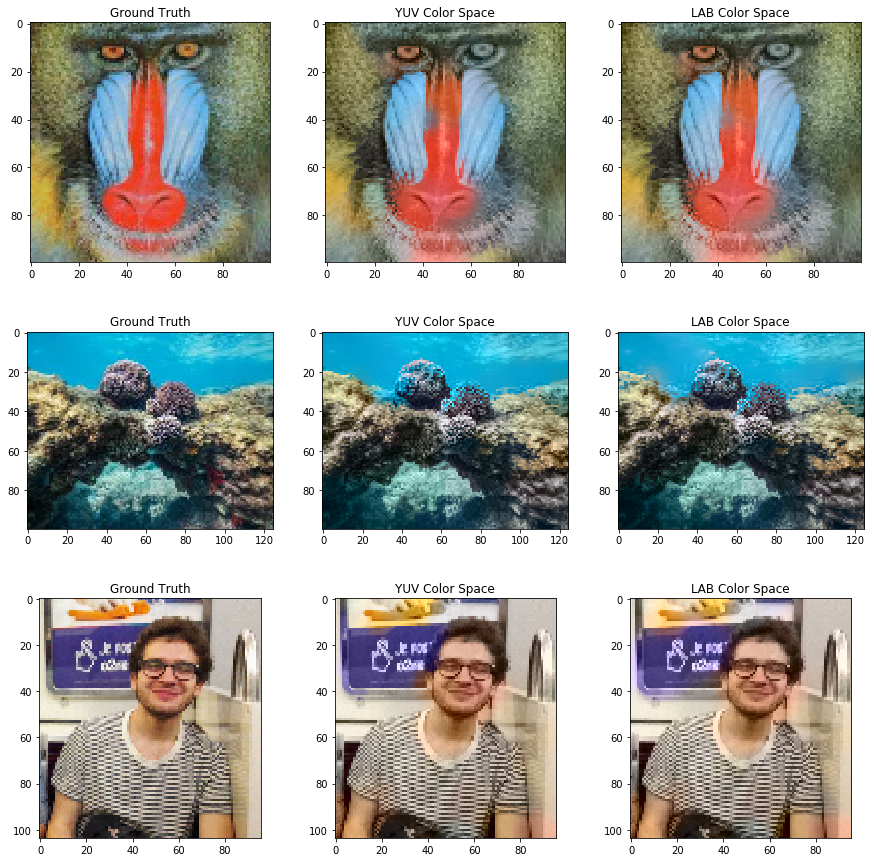

In [185]:
f,ax = plt.subplots(3,3,figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_babouin_yuv))
ax[0,0].set_title('Ground Truth')
ax[0,1].imshow(im_to_rgb(np.stack([Y_babouin_g, U_babouin_g[-1],
                                      V_babouin_g[-1]],axis=-1)))
ax[0,1].set_title('YUV Color Space')
ax[0,2].imshow(color.lab2rgb(np.stack([Y_babouin_lab_g, U_babouin_lab_g[-1],
                                      V_babouin_lab_g[-1]],axis=-1)))
ax[0,2].set_title('LAB Color Space')

ax[1,0].imshow(im_to_rgb(image_corail_yuv))
ax[1,0].set_title('Ground Truth')
ax[1,1].imshow(im_to_rgb(np.stack([Y_corail_g, U_corail_g[-1],
                                      V_corail_g[-1]],axis=-1)))
ax[1,1].set_title('YUV Color Space')
ax[1,2].imshow(color.lab2rgb(np.stack([Y_corail_lab_g, U_corail_lab_g[-1],
                                      V_corail_lab_g[-1]],axis=-1)))
ax[1,2].set_title('LAB Color Space')


ax[2,0].imshow(im_to_rgb(image_yo_yuv))
ax[2,0].set_title('Ground Truth')
ax[2,1].imshow(im_to_rgb(np.stack([Y_yo_g, U_yo_g[-1],
                                      V_yo_g[-1]],axis=-1)))
ax[2,1].set_title('YUV Color Space')
ax[2,2].imshow(color.lab2rgb(np.stack([Y_yo_lab_g, U_yo_lab_g[-1],
                                      V_yo_lab_g[-1]],axis=-1)))
ax[2,2].set_title('LAB Color Space')

f.show()   

# Iterative HFS Illustration

RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


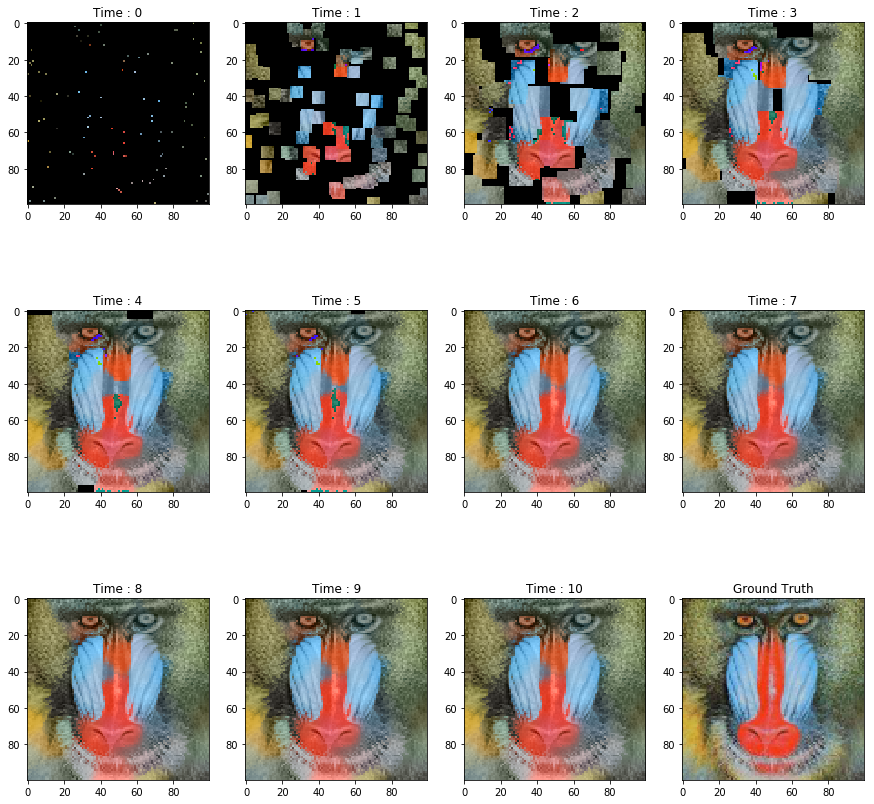

In [193]:
f,ax = plt.subplots(3,4, figsize=(15,15))
ax[0,0].imshow(im_to_rgb(image_init_babouin))
ax[0,0].set_title('Time : '+ str(0))
ax[0,1].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[0],V_babouin_g[0]], axis = -1))) 
ax[0,1].set_title('Time : '+ str(1))
ax[0,2].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[1],V_babouin_g[1]], axis = -1))) 
ax[0,2].set_title('Time : '+ str(2))
ax[0,3].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[2],V_babouin_g[2]], axis = -1))) 
ax[0,3].set_title('Time : '+ str(3))


ax[1,0].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[3],V_babouin_g[3]], axis = -1))) 
ax[1,0].set_title('Time : '+ str(4))
ax[1,1].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[4],V_babouin_g[4]], axis = -1))) 
ax[1,1].set_title('Time : '+ str(5))
ax[1,2].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[5],V_babouin_g[5]], axis = -1))) 
ax[1,2].set_title('Time : '+ str(6))
ax[1,3].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[6],V_babouin_g[6]], axis = -1))) 
ax[1,3].set_title('Time : '+ str(7))

ax[2,0].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[7],V_babouin_g[7]], axis = -1))) 
ax[2,0].set_title('Time : '+ str(8))
ax[2,1].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[8],V_babouin_g[8]], axis = -1))) 
ax[2,1].set_title('Time : '+ str(9))
ax[2,2].imshow(im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[9],V_babouin_g[9]], axis = -1))) 
ax[2,2].set_title('Time : '+ str(10))
ax[2,3].imshow(im_to_rgb(image_babouin_yuv))
ax[2,3].set_title('Ground Truth')

f.show()

# Comp with Color Space and Distance

RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1
RGB should be positive


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/color/colorconv.py:983: RuntimeWarning: invalid value encountered in less
  if np.any(z < 0):
/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/color/colorconv.py:990: RuntimeWarning: invalid value encountered in greater
  mask = out > 0.2068966
/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/color/colorconv.py:633: RuntimeWarning: invalid value encountered in greater
  mask = arr > 0.0031308
/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/color/colorconv.py:636: RuntimeWarning: invalid value encountered in less
  arr[arr < 0] = 0
/Users/yoanrussac/anaconda/lib/python3.5/site-packages/skimage/color/colorconv.py:637: RuntimeWarning: invalid value encountered in greater
  arr[arr > 1] = 1


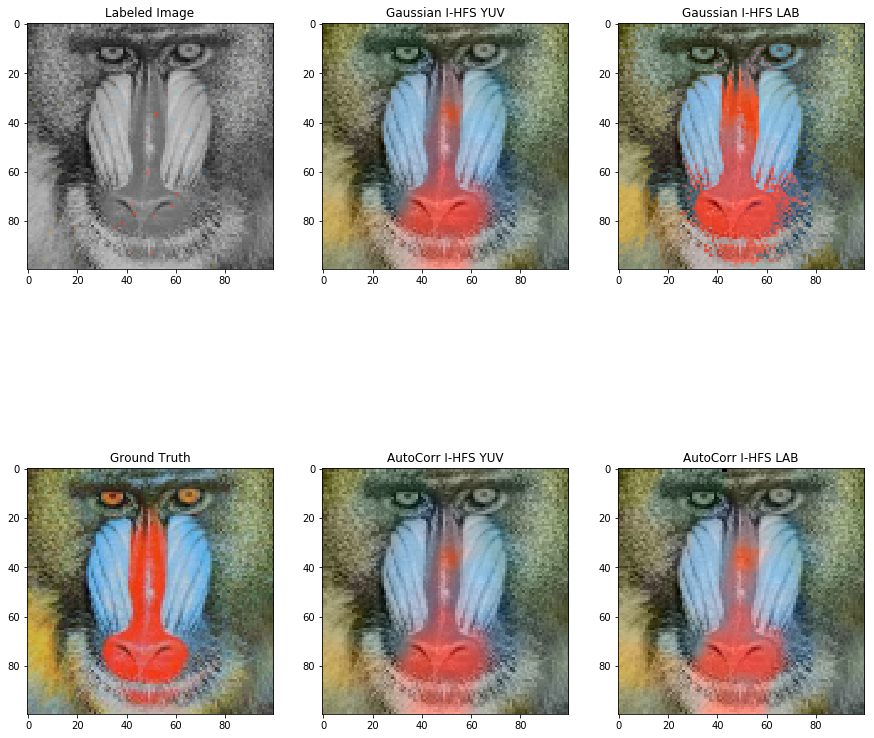

In [177]:
final_plot(image_init,image_singe_resized,Y_babouin_g,U_babouin_g, V_babouin_g,
           Y_babouin_ng,U_babouin_ng,V_babouin_ng,
           Y_babouin_lab_g,U_babouin_lab_g,V_babouin_lab_g,
           Y_babouin_lab_ng,U_babouin_lab_ng,V_babouin_lab_ng)

# Work on Color Histogram

RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


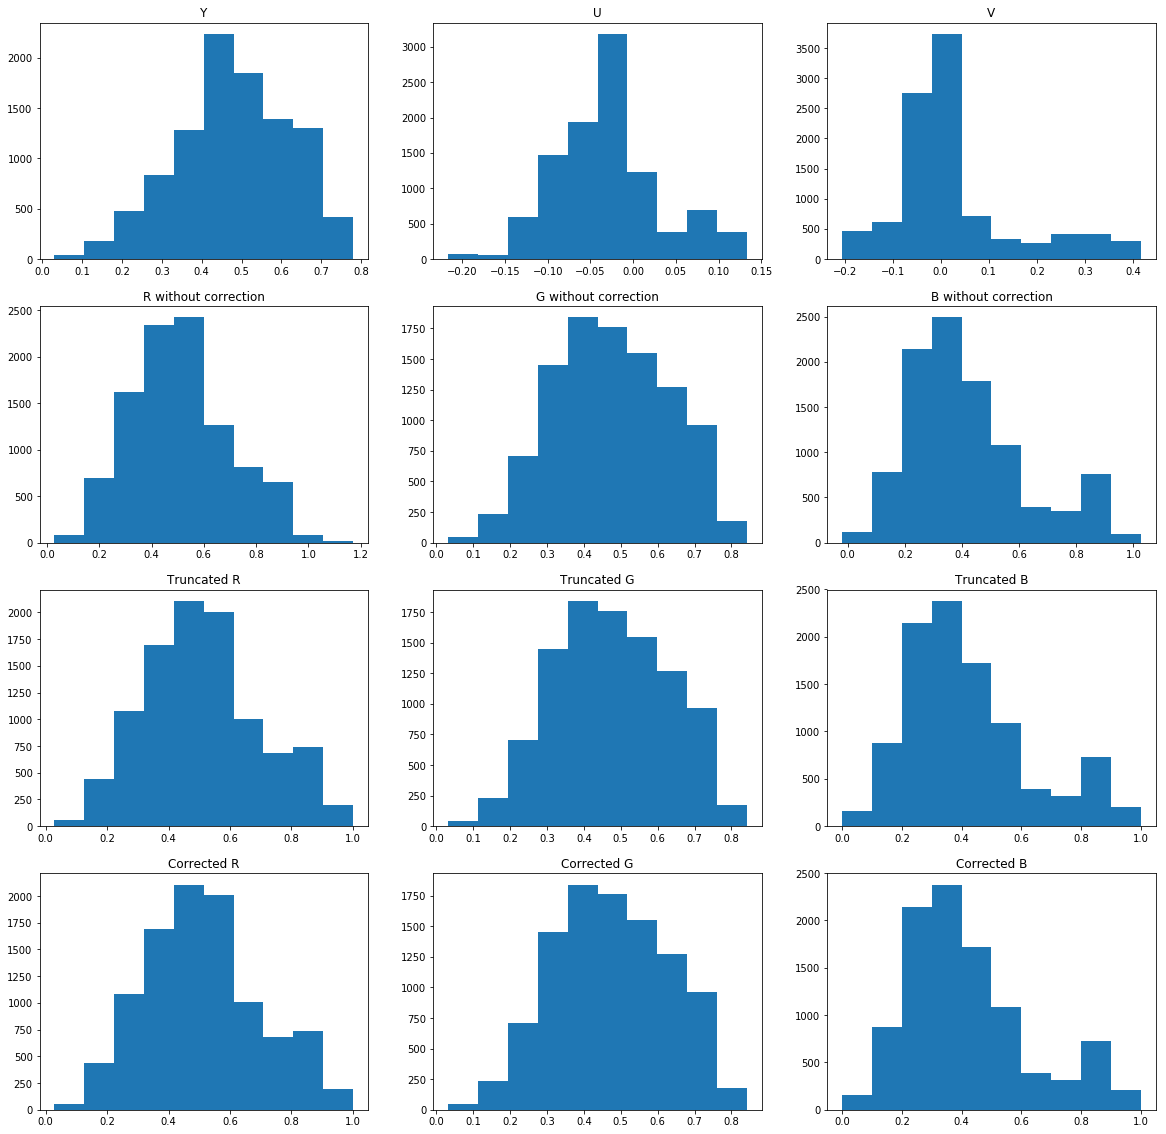

In [324]:
# Post iterative HFS transformation in YUV Space using gaussian distance- Ape image
f, ax = plt.subplots(4,3,figsize=(20,20))

im0 = np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1)
im1 = im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1))
im2 = im_to_rgb_without_correction(np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1))
im3 = im_to_rgb_corrected(np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1))


ax[0,0].hist(im0[:,:,0].flatten())
ax[0,0].set_title('Y')
ax[0,1].hist(im0[:,:,1].flatten())
ax[0,1].set_title('U')
ax[0,2].hist(im0[:,:,2].flatten())
ax[0,2].set_title('V')

ax[1,0].hist(im2[:,:,0].flatten())
ax[1,0].set_title('R without correction')
ax[1,1].hist(im2[:,:,1].flatten())
ax[1,1].set_title('G without correction')
ax[1,2].hist(im2[:,:,2].flatten())
ax[1,2].set_title('B without correction')

ax[2,0].hist(im1[:,:,0].flatten())
ax[2,0].set_title('Truncated R')
ax[2,1].hist(im1[:,:,1].flatten())
ax[2,1].set_title('Truncated G')
ax[2,2].hist(im1[:,:,2].flatten())
ax[2,2].set_title('Truncated B')

ax[3,0].hist(im1[:,:,0].flatten())
ax[3,0].set_title('Corrected R')
ax[3,1].hist(im1[:,:,1].flatten())
ax[3,1].set_title('Corrected G')
ax[3,2].hist(im1[:,:,2].flatten())
ax[3,2].set_title('Corrected B')


f.show()

RGB should be smaller than 1
RGB should be positive
RGB should be smaller than 1


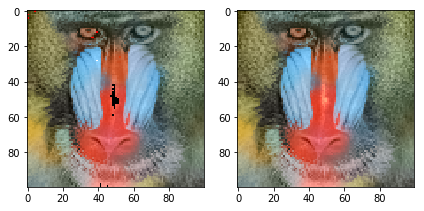

In [334]:
im1 = im_to_rgb(np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1))
im1_bis = im_to_rgb_corrected(np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1))
im1_ter = im_to_rgb_without_correction(np.stack([Y_babouin_g,U_babouin_g[-1],V_babouin_g[-1]], axis = -1))
io.imshow_collection([im1_ter, im1_bis])

RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be positive


/Users/yoanrussac/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


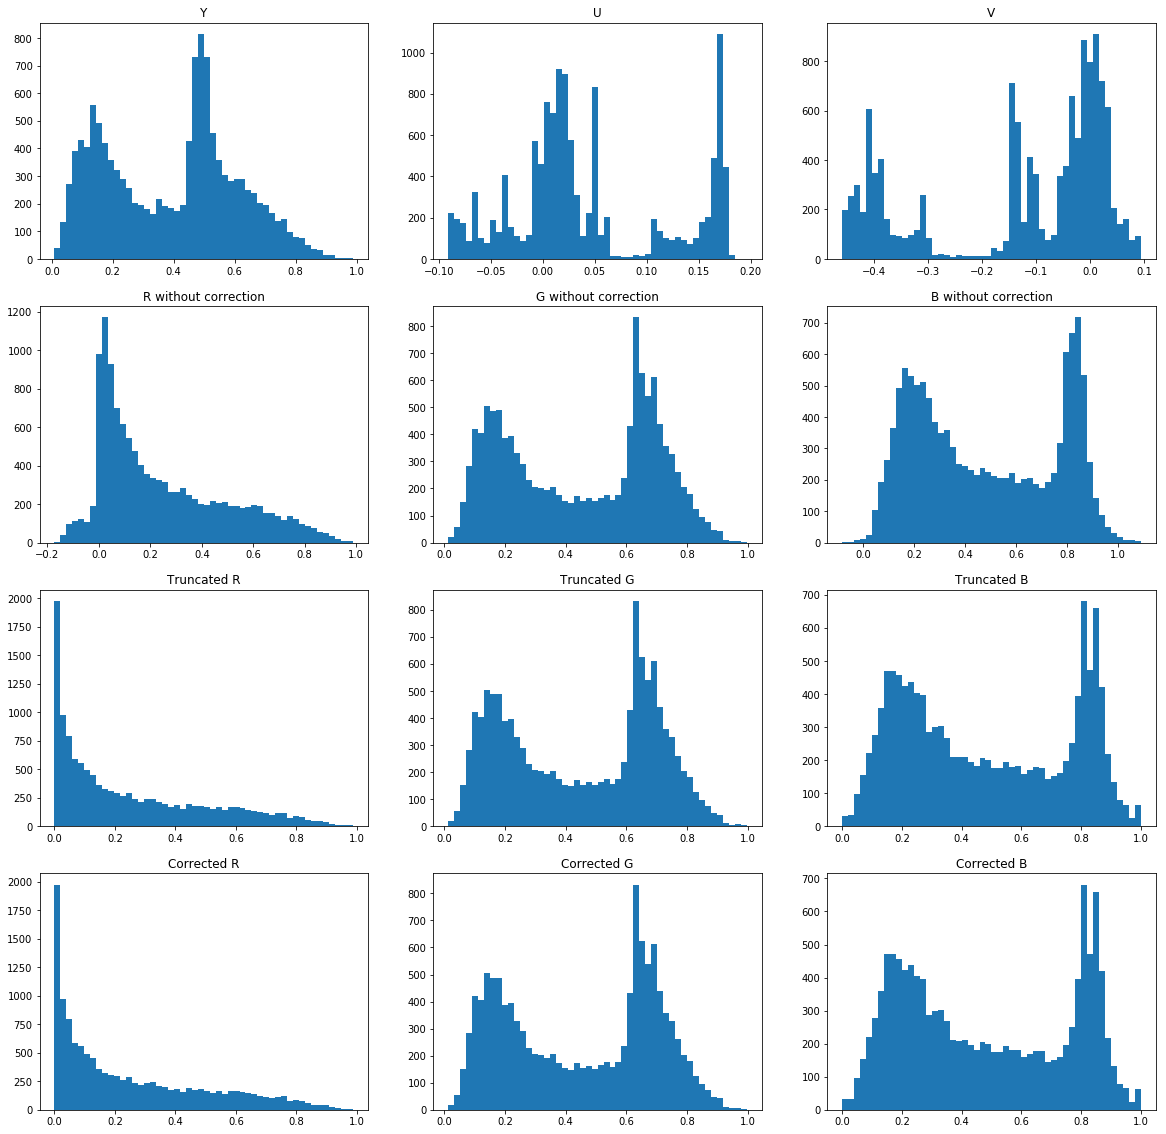

In [343]:
# Post iterative HFS transformation in YUV Space using gaussian distance- Ape image
f, ax = plt.subplots(4,3,figsize=(20,20))

im0 = np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1)
im1 = im_to_rgb(np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1))
im2 = im_to_rgb_without_correction(np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1))
im3 = im_to_rgb_corrected(np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1))


ax[0,0].hist(im0[:,:,0].flatten(),bins = 50)
ax[0,0].set_title('Y')
ax[0,1].hist(im0[:,:,1].flatten(),bins = 50)
ax[0,1].set_title('U')
ax[0,2].hist(im0[:,:,2].flatten(),bins = 50)
ax[0,2].set_title('V')

ax[1,0].hist(im2[:,:,0].flatten(),bins = 50)
ax[1,0].set_title('R without correction')
ax[1,1].hist(im2[:,:,1].flatten(),bins = 50)
ax[1,1].set_title('G without correction')
ax[1,2].hist(im2[:,:,2].flatten(),bins = 50)
ax[1,2].set_title('B without correction')

ax[2,0].hist(im1[:,:,0].flatten(),bins = 50)
ax[2,0].set_title('Truncated R')
ax[2,1].hist(im1[:,:,1].flatten(),bins = 50)
ax[2,1].set_title('Truncated G')
ax[2,2].hist(im1[:,:,2].flatten(),bins = 50)
ax[2,2].set_title('Truncated B')

ax[3,0].hist(im1[:,:,0].flatten(),bins = 50)
ax[3,0].set_title('Corrected R')
ax[3,1].hist(im1[:,:,1].flatten(),bins = 50)
ax[3,1].set_title('Corrected G')
ax[3,2].hist(im1[:,:,2].flatten(),bins = 50)
ax[3,2].set_title('Corrected B')


f.show()

RGB should be positive
RGB should be positive
RGB should be smaller than 1
RGB should be positive


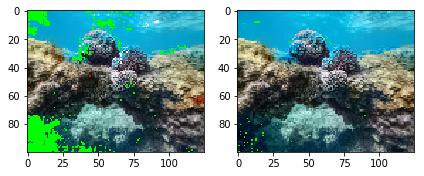

In [336]:
im2 = im_to_rgb(np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1))
im2_bis = im_to_rgb_corrected(np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1))
im2_ter = im_to_rgb_without_correction(np.stack([Y_corail_g,U_corail_g[-1],V_corail_g[-1]], axis = -1))
io.imshow_collection([im2_ter, im2_bis])

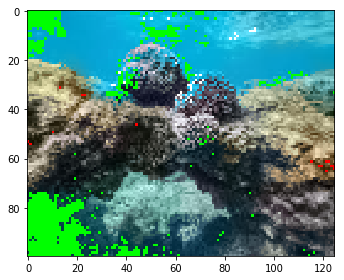

In [344]:
io.imshow(im2_ter)
